In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
  
# reading the csv file
dataset = "https://raw.githubusercontent.com/Negatix092/Machine-Learning/main/ML_Class_Spring_2023/Proyecto_Final/StudentsPerformance.csv"
df = pd.read_csv(dataset)

df.head()

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score
0,female,group B,bachelor's degree,standard,none,72,72,74
1,female,group C,some college,standard,completed,69,90,88
2,female,group B,master's degree,standard,none,90,95,93
3,male,group A,associate's degree,free/reduced,none,47,57,44
4,male,group C,some college,standard,none,76,78,75


In [2]:
#preparacion del dataset
from sklearn.metrics import classification_report  
from sklearn.metrics import confusion_matrix  
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split

#outputs
score_output_Math = 'math score'
score_output_Reading = 'reading score'
score_output_Writing = 'writing score'

#en la lista binary_feat se almacenan los nombres de las columnas (del dataset) que solamente tienen dos valores diferentes.
binary_feat = df.nunique()[df.nunique() == 2].keys().tolist()
#en la lista numeric_feat se almacenan los nombres de las columnas (del dataset) que solamente contienen datos numericos, sean tipo int o float, y que no tienen solo dos valores diferentes
numeric_feat = [col for col in df.select_dtypes(['float','int']).columns.tolist() if col not in binary_feat]
#en la lista categorical_feat se almacenan los nombres de las columnas (del dataset) que tienen datos no numericos y que no tienen solo dos valores diferentes.
categorical_feat = [ col for col in df.select_dtypes('object').columns.to_list() if col not in binary_feat + numeric_feat ]
#una copa del dataframe (dataset) se almacena en un nuevo dataframe para trabajarlo, df_proc
df_proc = df.copy()

#Etiquetas para características binarias
#aqui se transforman los binary features (solo dos valores diferentes) a valores numericos usando LabelEncoder
le = LabelEncoder()
for i in binary_feat:
  df_proc[i] = le.fit_transform(df_proc[i])
  print(i, '\n', np.unique(df_proc[i].values))

def get_df_size(df, header='Dataset dimensions'):
  print(header,
        '\n# Attributes: ', df.shape[1], 
        '\n# Entries: ', df.shape[0],'\n')
  
#Dummy variables
#se crean variables dummy para las categorical features
#a cada categorical feature se la convierte en multiples binary features, con un valor posible (0 o 1) para cada categorical feature original
# es decir, one-hot encoding se aplica a las categorical features
get_df_size(df_proc, header='Processed dataset before dummies:')
df_proc = pd.get_dummies(df_proc, columns=categorical_feat)
get_df_size(df, header='Original dataset:')
get_df_size(df_proc, header='Processed dataset:')
df_proc.head()

gender 
 [0 1]
lunch 
 [0 1]
test preparation course 
 [0 1]
Processed dataset before dummies: 
# Attributes:  8 
# Entries:  1000 

Original dataset: 
# Attributes:  8 
# Entries:  1000 

Processed dataset: 
# Attributes:  17 
# Entries:  1000 



,gender,lunch,test preparation course,math score,reading score,writing score,race/ethnicity_group A,race/ethnicity_group B,race/ethnicity_group C,race/ethnicity_group D,race/ethnicity_group E,parental level of education_associate's degree,parental level of education_bachelor's degree,parental level of education_high school,parental level of education_master's degree,parental level of education_some college,parental level of education_some high school
0,0,1,1,72,72,74,False,True,False,False,False,False,True,False,False,False,False
1,0,1,0,69,90,88,False,False,True,False,False,False,False,False,False,True,False
2,0,1,1,90,95,93,False,True,False,False,False,False,False,False,True,False,False
3,1,0,1,47,57,44,True,False,False,False,False,True,False,False,False,False,False
4,1,1,1,76,78,75,False,False,True,False,False,False,False,False,False,True,False


In [3]:
# inputs y outputs
math_score_Y = df_proc['math score']
reading_score_Y = df_proc['reading score']
writing_score_Y = df_proc['writing score']

all_X=df_proc.drop(columns =['math score','reading score','writing score'], axis=1)

all_Y = df_proc.iloc[:, 3:6].values

# Dividimos el conjunto de entrenamiento y test
all_X_values_train = all_X[:-200] 
all_X_values_test = all_X[-200:] #last 200 for test

#split the targets into training/testing sets
#math_score_Y_train = math_score_Y[:-200]
#math_score_Y_test = math_score_Y[-200:] 
all_Y_values_train = all_Y[:-200] 
all_Y_values_test = all_Y[-200:] #last 200 for test

In [4]:
all_Y_values_train.shape

(800, 3)

In [7]:
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.multioutput import MultiOutputRegressor
from sklearn.linear_model import Ridge
from sklearn.feature_selection import SelectKBest
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.feature_selection import SelectKBest, f_regression

# Create a pipeline for the Ridge regression with feature selection
ridge_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('selector', SelectKBest(score_func=f_regression)),
    ('poly', PolynomialFeatures()),
    ('regressor', Ridge())
])

# Create a dictionary of hyperparameters for the pipeline
ridge_hyperparameters = {
    'estimator__selector__k': range(1, 15),
    'estimator__poly__degree':[0,1,2],
    'estimator__regressor__alpha': [0.1, 1.0, 10.0, 100]
}

# Create a MultiOutputRegressor wrapper around the Ridge pipeline for multiple output regression
multi_output_ridge_pipeline = MultiOutputRegressor(ridge_pipeline)

cvm = RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=26)

# Create a grid search object with cross-validation for hyperparameter tuning
ridge_grid_search = GridSearchCV(multi_output_ridge_pipeline, ridge_hyperparameters, cv=10, scoring='r2')

result_ridge = ridge_grid_search.fit(all_X_values_train, all_Y_values_train)

#se quiere encontrar los mejores hiperparametros
best_hp_mridge = result_ridge.best_params_
print("Los mejores hiperparámetros para Multi-Ridge son:", best_hp_mridge)

Los mejores hiperparámetros para Multi-Ridge son: {'estimator__poly__degree': 1, 'estimator__regressor__alpha': 100, 'estimator__selector__k': 14}


Mean squared error: 175.31
RMean squared error: 13.24
Mean absolute error: 10.74
R2 score: 0.26


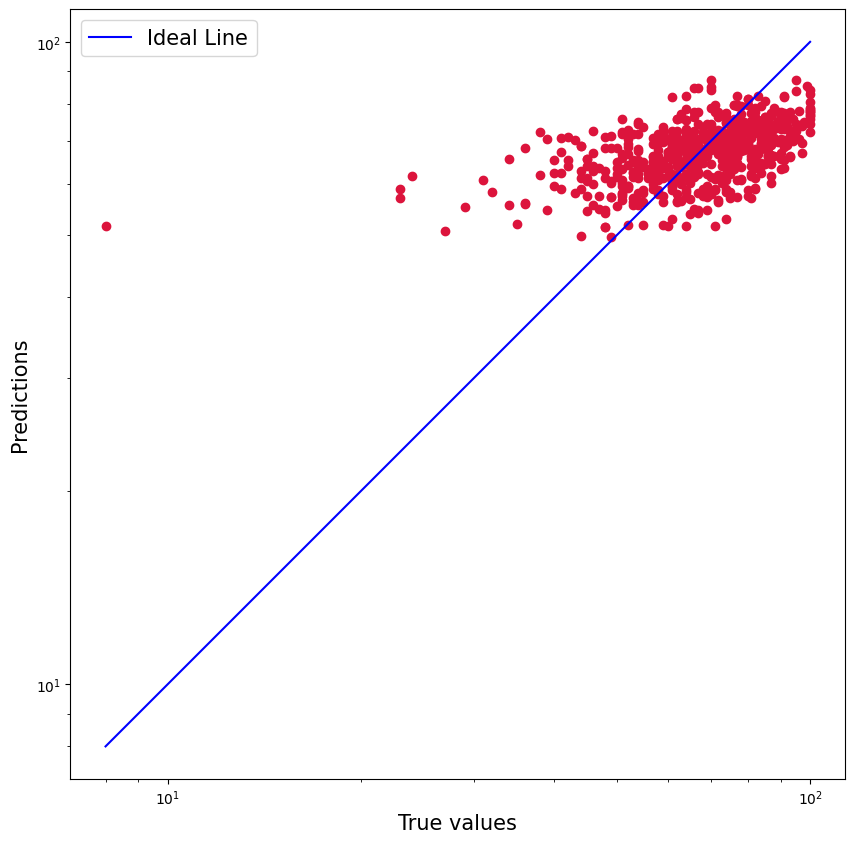

In [14]:
#conociendo los mejores hiperparametros del modelo, se crea el modelo con esos hiperparametros
best_mridge_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('selector', SelectKBest(score_func=f_regression, k=14)),
    ('poly', PolynomialFeatures(degree=1)),
    ('regressor', Ridge(alpha=100))
])

# Create a MultiOutputRegressor wrapper around the Ridge pipeline for multiple output regression
best_multi_output_ridge_pipeline = MultiOutputRegressor(best_mridge_pipeline)

#se entrena el modelo
best_multi_output_ridge_pipeline.fit(all_X_values_train, all_Y_values_train)

#se hacen las predicciones
all_Y_values_pred = best_multi_output_ridge_pipeline.predict(all_X_values_test)

#se calcula el error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

import math 

print("Mean squared error: %.2f" % mean_squared_error(all_Y_values_test, all_Y_values_pred))
print("RMean squared error: %.2f" % math.sqrt(mean_squared_error(all_Y_values_test, all_Y_values_pred)))
print("Mean absolute error: %.2f" % mean_absolute_error(all_Y_values_test, all_Y_values_pred))
print('R2 score: %.2f' % r2_score(all_Y_values_test, all_Y_values_pred))

#se grafica el error
plt.figure(figsize=(10, 10))
plt.scatter(all_Y_values_test, all_Y_values_pred, c='crimson')
plt.yscale('log')
plt.xscale('log')
p1 = np.amax([np.amax(all_Y_values_pred), np.amax(all_Y_values_test)])
p2 = np.amin([np.amin(all_Y_values_pred), np.amin(all_Y_values_test)])
plt.plot([p1, p2], [p1, p2], 'b-', label = 'Ideal Line')
plt.xlabel('True values', fontsize=15)
plt.ylabel('Predictions', fontsize=15)
plt.axis('equal')
plt.legend(fontsize=15)
plt.show()

In [15]:
all_Y_values_pred.shape

(200, 3)